# Project Work - IRM24
## Jürgen Aumayr & Natalia Trudova

### Random Forest

### Datenimport und Vorverarbeitung

In dieser Zelle werden die notwendigen Bibliotheken importiert, und der Titanic-Datensatz wird eingelesen. Die Datentypen werden optimiert, um Speicherplatz zu sparen.

In [2]:
# Importieren der notwendigen Bibliotheken
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Optimierte Datentypen definieren, um Speicherverbrauch zu reduzieren
dtypes = {
    'PassengerId': 'int32',
    'Survived': 'int8',
    'Pclass': 'int8',
    'Name': 'str',
    'Sex': 'category',
    'Age': 'float32',
    'SibSp': 'int8',
    'Parch': 'int8',
    'Ticket': 'str',
    'Fare': 'float32',
    'Cabin': 'str',
    'Embarked': 'category'
}

# Titanic-Daten einlesen
train_df = pd.read_csv('data/train.csv', dtype=dtypes)

# Ersten drei Zeilen des Datensatzes anzeigen
display(train_df.head(3))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250000,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.283302,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925000,NaN,S


### Feature Engineering

Diese Funktion verarbeitet die Rohdaten und erstellt neue Features, die für das Modelltraining verwendet werden. Es werden fehlende Werte behandelt und numerische Features erstellt.

In [3]:
def preprocess_features(df):
    """
    Bereitet die Titanic-Daten für das Modelltraining vor und
    erzeugt optimierte Features aus den Rohdaten.
    """
    # Kopie erstellen, um Originaldaten nicht zu verändern
    dataset = df.copy()
    
    # Geschlecht in numerisch konvertieren
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1})
    
    # Fehlende Alterswerte mit Median füllen - nach Klasse und Geschlecht gruppiert
    age_median = dataset.groupby(['Pclass', 'Sex'])['Age'].transform('median')
    dataset['Age'] = dataset['Age'].fillna(age_median)

    # NaN-Werte durch den Median ersetzen
    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())
    
    # Alter in Kategorien einteilen
    dataset['Age'] = pd.cut(
        dataset['Age'], 
        bins=[0, 18, 60, np.inf], 
        labels=[1, 2, 3]
    ).astype('int8')
    
    # Fahrpreise in Quartile einteilen für bessere Vergleichbarkeit
    dataset['Fare'] = pd.qcut(
        dataset['Fare'], 
        q=4, 
        labels=[0, 1, 2, 3],
        duplicates='drop'  # Verhindert Fehler bei doppelten Grenzwerten
    ).astype('int8')
    
    # Einschiffungshafen in numerische Werte umwandeln
    dataset['Embarked'] = dataset['Embarked'].fillna(dataset['Embarked'].mode()[0])
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype('int8')
    
    # Binäres Merkmal: Hat der Passagier eine Kabinennummer oder nicht?
    dataset['Has_Cabin'] = (dataset['Cabin'].notna()).astype('int8')
    
    # Berechnung der Familiengröße und Alleinreisenden-Status
    dataset['FamilySize'] = (dataset['SibSp'] + dataset['Parch'] + 1).astype('int8')
    dataset['IsAlone'] = (dataset['FamilySize'] == 1).astype('int8')
    
    # Titel aus Namen extrahieren mit regulärem Ausdruck - effizienter als Split
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # Titel-Mapping für Kategorisierung
    title_mapping = {
        "Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5
    }
    
    # Seltenere Titel zusammenfassen, um Overfitting zu vermeiden
    rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 
                   'Major', 'Rev', 'Sir', 'Jonkheer', 'Mlle', 'Mme', 'Ms']
    dataset['Title'] = dataset['Title'].replace(rare_titles, 'Rare')
    dataset['Title'] = dataset['Title'].map(title_mapping).fillna(5).astype('int8')
    
    return dataset

# Daten vorverarbeiten und relevante Features auswählen
processed_df = preprocess_features(train_df)
features_df = processed_df[['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 
                            'Fare', 'Embarked', 'Has_Cabin', 'FamilySize', 
                            'IsAlone', 'Title']]

# Vorverarbeitete Features anzeigen
display(features_df.head(3))

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,2,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,2,0,1,0,0,1,1,4


### Datenaufteilung

In [4]:
# Features und Zielvariable trennen
X = features_df.drop('Survived', axis=1)
y = features_df['Survived']

# Daten aufteilen: Trainings- und Validierungsset (80% Training / 20% Test)
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

### Modelltraining mit Random Forest

Hier wird ein Random Forest-Modell trainiert. Die Hyperparameter werden mit GridSearchCV optimiert.

In [6]:
# Hyperparameter-Grid für Random Forest
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [4, 6],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

# GridSearchCV für Hyperparameter-Tuning verwenden
grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    n_jobs=-1,
)

# Modell trainieren
grid_search_rf.fit(X_train, y_train)

# Beste Parameter anzeigen
print(f"Beste Parameter: {grid_search_rf.best_params_}")

Beste Parameter: {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


### Evaluierung des Modells

Das optimierte Modell wird auf dem Validierungsset getestet. Die Accuracy sowie ein Klassifikationsbericht werden ausgegeben.

In [8]:
# Bestes Modell auswählen und Vorhersagen treffen
best_rf_model = grid_search_rf.best_estimator_
val_predictions = best_rf_model.predict(X_val)

# Genauigkeit berechnen
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validierungsgenauigkeit: {val_accuracy:.4f}")

# Klassifikationsbericht ausgeben
print("Klassifikationsbericht:")
print(classification_report(y_val, val_predictions))

Validierungsgenauigkeit: 0.7989
Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       110
           1       0.77      0.68      0.72        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179



### Feature-Wichtigkeit analysieren

Die Wichtigkeit der Features im Random Forest wird visualisiert.

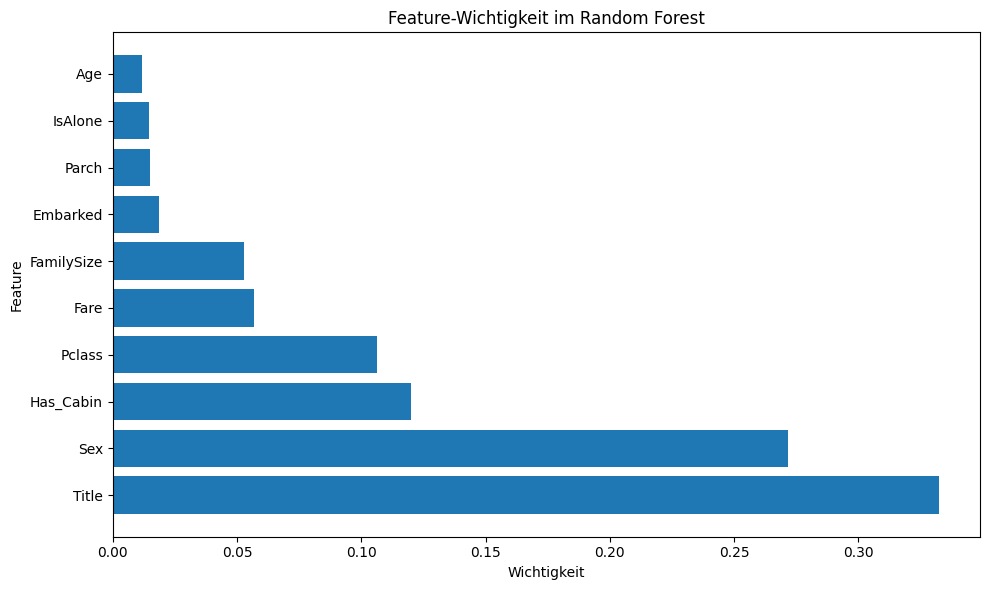

In [9]:
import matplotlib.pyplot as plt

feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_rf_model.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance["Feature"], feature_importance["Importance"])
plt.xlabel("Wichtigkeit")
plt.ylabel("Feature")
plt.title("Feature-Wichtigkeit im Random Forest")
plt.tight_layout()
plt.show()

### Vorhersagen für Testdaten

Die Testdaten werden vorverarbeitet und die Vorhersagen des Modells exportiert.

,PassengerId,Name,Sex,Survived
0,892,"Kelly, Mr. James",male,0
1,893,"Wilkes, Mrs. James (Ellen Needs)",female,1
2,894,"Myles, Mr. Thomas Francis",male,0
3,895,"Wirz, Mr. Albert",male,0
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,1
5,897,"Svensson, Mr. Johan Cervin",male,0
6,898,"Connolly, Miss. Kate",female,1
7,899,"Caldwell, Mr. Albert Francis",male,0
8,900,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,1
9,901,"Davies, Mr. John Samuel",male,0


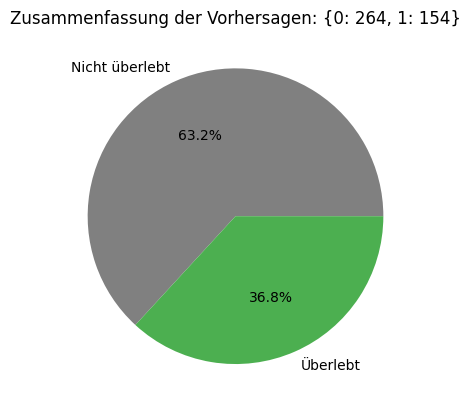

In [14]:
# Test-Daten laden und vorverarbeiten
test_df = pd.read_csv("data/test.csv", dtype=dtypes)
test_processed = preprocess_features(test_df)

# Relevante Features auswählen
X_test = test_processed[X.columns]

# Vorhersagen mit dem optimierten Modell
test_predictions = best_rf_model.predict(X_test)

# Ergebnisse für den Export vorbereiten
submission = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
     'Name': test_df['Name'],
    'Sex': test_df['Sex'],
    "Survived": test_predictions,
})

# Optimierte CSV-Speicherung ohne Indexspalte und mit effizienter Kompression
submission.to_csv("submission_rf.csv", index=False, encoding='utf-8')

# Anzeigen der ersten Datensätze der Vorhersage
display(submission.head(10))

# Erstelle Pie Chart zur Visualiserung der Vorhersage
survivors = submission['Survived'].value_counts().to_dict()
piechart = np.array([survivors.get(0), survivors.get(1)])
survlabels = ["Nicht überlebt", "Überlebt"]
survcolors = ["grey", "#4CAF50"]
plt.title(f"Zusammenfassung der Vorhersagen: {submission['Survived'].value_counts().to_dict()}")
plt.pie(piechart, labels = survlabels, colors = survcolors, autopct='%1.1f%%')
plt.show() 